<a href="https://colab.research.google.com/github/Smarttoolz/-Diabetes-Prediction-Using-Streamlit-/blob/main/diabetes_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Load the new dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/diabetes_prediction_dataset.csv"
data = pd.read_csv(file_path)
df = data

In [ ]:
# Step 2: Exploratory Data Analysis (EDA)
print("Dataset Preview:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nClass Distribution:")
print(df['diabetes'].value_counts(normalize=True))

Dataset Preview:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Summary Statistics:
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.

In [ ]:
# Check for zero values in numerical columns
print("\nZero Values (Potential Missing):")
for col in ['bmi', 'HbA1c_level', 'blood_glucose_level']:
    print(f"{col}: {len(df[df[col] == 0])} zeros")


Zero Values (Potential Missing):
bmi: 0 zeros
HbA1c_level: 0 zeros
blood_glucose_level: 0 zeros


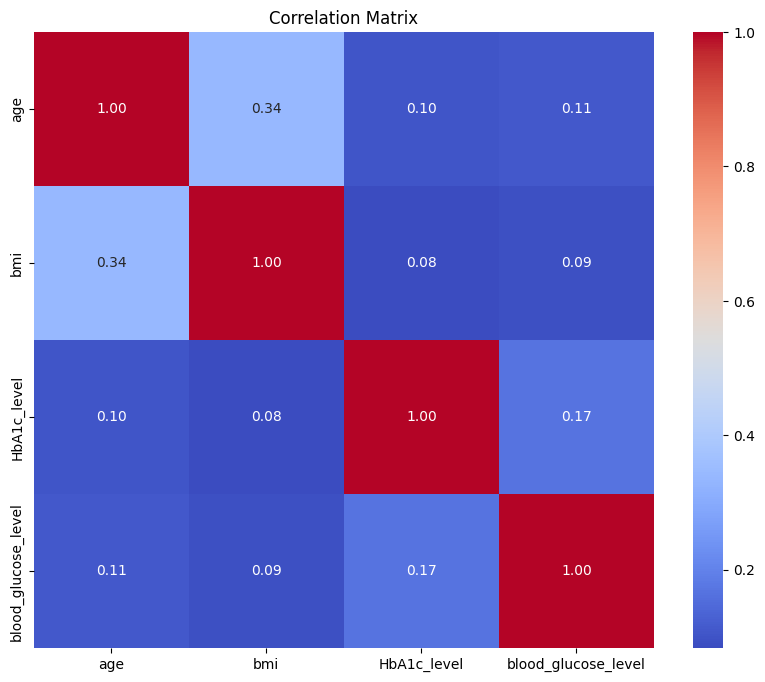

In [ ]:
# Correlation matrix (only numerical features)
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

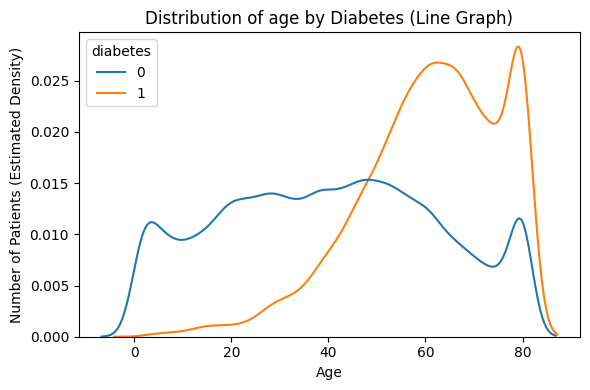

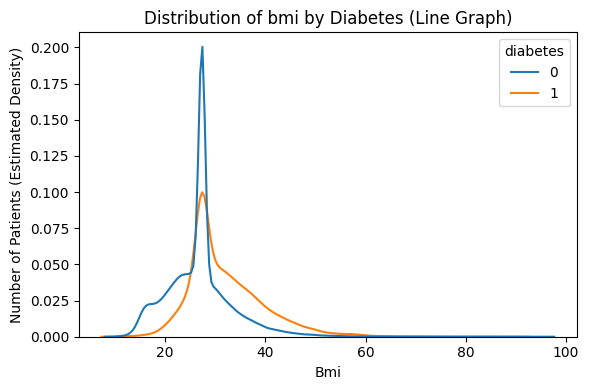

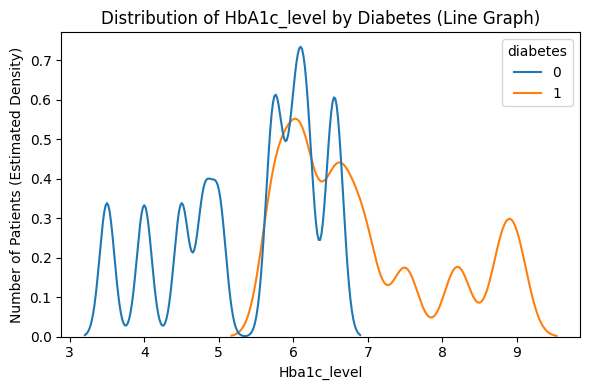

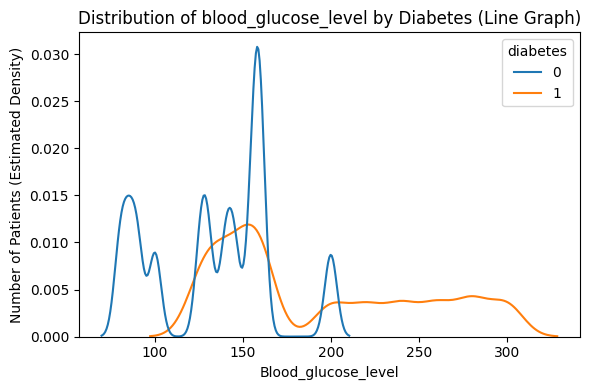

In [ ]:
# Feature distributions as line graphs (count-based KDE)
key_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for feature in key_features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(
        data=df,
        x=feature,
        hue='diabetes',
        common_norm=False,   # prevent normalization across classes
        fill=False,          # line graph only
        multiple="layer"     # overlay both lines
    )
    plt.xlabel(feature.capitalize())
    plt.ylabel("Number of Patients (Estimated Density)")
    plt.title(f'Distribution of {feature} by Diabetes (Line Graph)')
    plt.tight_layout()
    plt.savefig(f'{feature}_line_distribution.png')
    plt.show()


In [ ]:
# Step 3: Data Preprocessing
# Define feature types
categorical_cols = ['gender', 'smoking_history', 'hypertension', 'heart_disease']
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Replace 'No Info' in smoking_history with NaN
df['smoking_history'] = df['smoking_history'].replace('No Info', np.nan)

In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors=3)),  # Use KNNImputer for numerical features
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute categorical with mode
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [ ]:
# Apply preprocessing
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_preprocessed = preprocessor.fit_transform(X)

# Save preprocessor
joblib.dump(preprocessor, '/content/drive/MyDrive/Colab Notebooks/preprocessor.pkl')

['/content/drive/MyDrive/Colab Notebooks/preprocessor.pkl']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, stratify=y, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
try:
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
except ValueError as e:
    print(f"SMOTE failed: {e}. Proceeding without balancing.")
    X_train_balanced, y_train_balanced = X_train, y_train

In [ ]:
# Model Development
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=50),
    'KNN': KNeighborsClassifier(n_neighbors=3)
}

In [ ]:
# Model Training and Evaluation
results = []
for name, model in models.items():
    # Train model
    model.fit(X_train_balanced, y_train_balanced)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }

    # Cross-validation score
    try:
        cv_scores = cross_val_score(model, X_preprocessed, y, cv=3, scoring='f1')
        metrics['CV F1 Mean'] = cv_scores.mean()
        metrics['CV F1 Std'] = cv_scores.std()
    except ValueError:
        metrics['CV F1 Mean'] = np.nan
        metrics['CV F1 Std'] = np.nan

    results.append(metrics)

In [ ]:
# Step 7: Save Best Model
results_df = pd.DataFrame(results)
best_model_row = results_df.loc[results_df['F1-Score'].idxmax()]
best_model_name = best_model_row['Model']
best_model = models[best_model_name]
joblib.dump(best_model, f'{best_model_name.lower().replace(" ", "_")}_model.pkl')


['random_forest_model.pkl']

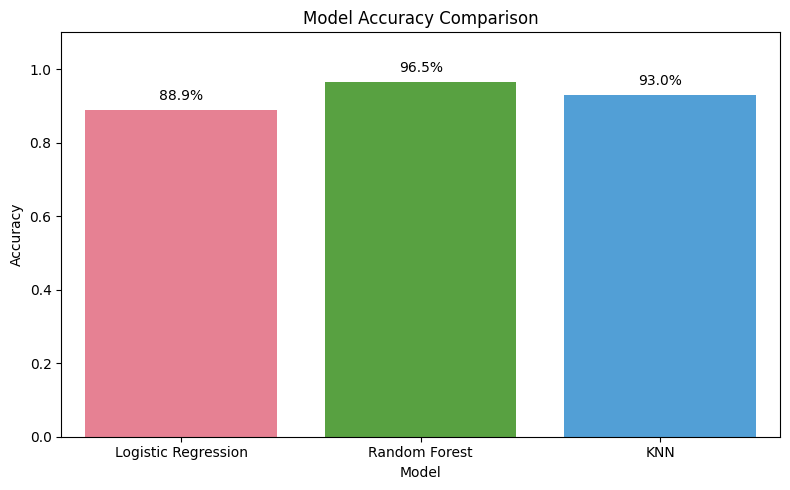

In [ ]:
# Step 8: Plot Accuracy Comparison
plt.figure(figsize=(8, 5))
# Define a custom color palette
colors = sns.color_palette("husl", len(results_df))  # Use 'husl' palette for distinct colors
sns.barplot(x='Model', y='Accuracy', data=results_df, palette=colors)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1.1)  # Extend y-axis slightly to accommodate percentage labels

# Add percentage labels on top of each bar
for i, row in results_df.iterrows():
    plt.text(i, row['Accuracy'] + 0.02, f'{row["Accuracy"]*100:.1f}%',
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.savefig('accuracy_comparison.png')
plt.show()

In [ ]:
# Step 9: Summarize Results
print("\nModel Performance Summary:")
print(results_df)
print("\nBest Model (Highest F1-Score):")
print(best_model_row)


Model Performance Summary:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0  Logistic Regression  0.888567   0.425033  0.881569  0.573543  0.961843   
1        Random Forest  0.964500   0.836735  0.723529  0.776025  0.961992   
2                  KNN  0.929533   0.564497  0.748235  0.643508  0.878364   

   CV F1 Mean  CV F1 Std  
0    0.726928   0.003455  
1    0.792975   0.003971  
2    0.724878   0.002425  

Best Model (Highest F1-Score):
Model         Random Forest
Accuracy             0.9645
Precision          0.836735
Recall             0.723529
F1-Score           0.776025
ROC-AUC            0.961992
CV F1 Mean         0.792975
CV F1 Std          0.003971
Name: 1, dtype: object


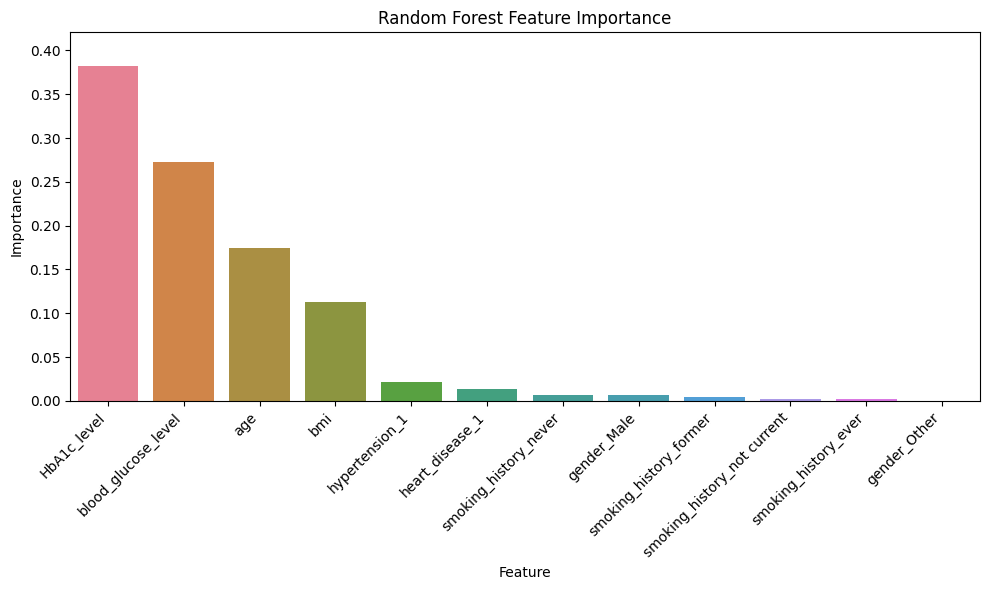


Feature Importance:
                        Feature  Importance
2                   HbA1c_level    0.382360
3           blood_glucose_level    0.272951
0                           age    0.174538
1                           bmi    0.112324
10               hypertension_1    0.021977
11              heart_disease_1    0.013696
8         smoking_history_never    0.006954
4                   gender_Male    0.006491
7        smoking_history_former    0.003940
9   smoking_history_not current    0.002645
6          smoking_history_ever    0.002115
5                  gender_Other    0.000009


In [ ]:
# Step 6.1: Feature Importance Plot for Random Forest
# Extract the Random Forest model
rf_model = models['Random Forest']
rf_model.fit(X_train_balanced, y_train_balanced)

# Get feature names after preprocessing
feature_names = (numerical_cols +
                 preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols).tolist())

# Get feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(feature_importance_df))  # Distinct colors for each feature
sns.barplot(x='Feature', y='Importance', data=feature_importance_df, palette=colors)
plt.title('Random Forest Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(feature_importance_df['Importance']) * 1.1)  # Extend y-axis for labels


plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Print feature importance
print("\nFeature Importance:")
print(feature_importance_df)

In [ ]:
# Install required packages
!pip install pyngrok streamlit
!pip install lime


# Import necessary libraries
from pyngrok import ngrok
import subprocess
import threading
import time
import os

NGROK_AUTHTOKEN = "31SxtSCGyhbOxf7tJCNsYBX14M2_2YezzrN66MHXLh47GeDnQ"  # e.g., "2FzA5b3C...W8yZ9"

APP_FILE = "/content/drive/MyDrive/Colab Notebooks/app.py"  # Make sure this matches your filename

if not os.path.exists(APP_FILE):
    raise FileNotFoundError(f"Error: Could not find {APP_FILE} in the current directory")

ngrok.set_auth_token(NGROK_AUTHTOKEN)
print("Ngrok authentication successful")

def run_streamlit():
    """Function to run Streamlit in the background"""
    subprocess.run([
        "streamlit",
        "run",
        "--server.port", "8501",
        "--server.address", "0.0.0.0",
        APP_FILE
    ])

# Start Streamlit in a separate thread
thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()

# Wait for Streamlit to initialize
print("Starting Streamlit server...")
time.sleep(5)

# --- NGROK TUNNEL SETUP ---
try:
    # Kill any existing tunnels
    ngrok.kill()

    # Create new HTTPS tunnel
    public_url = ngrok.connect(addr="8501", bind_tls=True)
    print("\n" + "="*50)
    print("Streamlit app is now running at:")
    print(f"\n  🔗 {public_url}\n")
    print("="*50)
    print("\nPress Ctrl+C to stop the server when done")

    # Keep the connection alive
    while True:
        time.sleep(10)

except KeyboardInterrupt:
    print("\nShutting down servers...")
    ngrok.kill()
    print("Successfully terminated all connections")
except Exception as e:
    print(f"Error occurred: {str(e)}")
    ngrok.kill()

Ngrok authentication successful
Starting Streamlit server...

Streamlit app is now running at:

  🔗 NgrokTunnel: "https://4066611f855d.ngrok-free.app" -> "http://localhost:8501"


Press Ctrl+C to stop the server when done

Shutting down servers...
Successfully terminated all connections
